# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [76]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [77]:
churn.shape

# checking the size of the data.

(46206, 21)

In [79]:
churn = churn.drop(churn.index[(churn['AGE'] > 100) | (churn['AGE'] < 10)])

# removed the outliers in AGE column where age was above 100 and less than 10.

In [80]:
churn = churn.drop(['COUNTRY_METRO_REGION', 'STATE' , 'RECON_SMS_NEXT_MTH' , 'RECON_TELE_NEXT_MTH' , 'RECON_EMAIL_NEXT_MTH' , 'HANDSET_USED_BRAND'], axis = 1)
churn
# Removing the recon and other unwanted columns

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
INDEX,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,1,61.40
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,1,54.54
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,1,2.50
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,1,6.48
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,1,100.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46202,79494,10,1,61.0,CONSUMER,9,27.27,BYO,7,0,0,NO-CONTRACT,0,0,27.27
46203,79495,2,1,53.0,CONSUMER,2,54.54,NON BYO,2,0,24,OFF-CONTRACT,24,1,54.99
46204,79496,47,1,22.0,CONSUMER,47,72.72,NON BYO,7,17,24,ON-CONTRACT,24,0,72.72


In [71]:
churn.shape

(46128, 15)

In [96]:
g1 = churn.groupby(churn['CONTRACT_STATUS']).agg(['count'])
g1.CUST_ID

# grouped the dataframe by contract_status

,count
CONTRACT_STATUS,
NO-CONTRACT,5459
OFF-CONTRACT,12434
ON-CONTRACT,28235


The above table contains number of customers with NO-CONTRACT, OFF-CONTRACT and ON-CONTRACT.

In [97]:
print("No. of samples for 0 CHURN_IND: ", churn[churn['CHURN_IND'] == 0].shape[0])
print("No. of samples for 1 CHURN_IND: ", churn[churn['CHURN_IND'] == 1].shape[0])

No. of samples for 0 CHURN_IND:  28365
No. of samples for 1 CHURN_IND:  17763


CHURN_IND with 0 value  means that customers are still connected with the service and CHURN_IND with 1 value means that the customers have left the service. So, from this dataset we can observe that 28365 are still connected with services whereas 17763 have left the sevice.

In [102]:
churn = churn.fillna(method='bfill')

#used bfill function to fill the NA values in the dataset

In [99]:
churn.CFU.replace({"CONSUMER":1, "SMALL BUSINESS":0}, inplace = True)
churn.BYO_PLAN_STATUS.replace({"BYO":1, "NON BYO":0}, inplace = True)

# to use categorical columns the values of these columns are changed to binary values.

In [100]:
dummy_churn = pd.get_dummies(churn)

# dummy values are used to covert categorical values to binry values

In [101]:
dummy_churn.tail(15)

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,CONTRACT_STATUS_NO-CONTRACT,CONTRACT_STATUS_OFF-CONTRACT,CONTRACT_STATUS_ON-CONTRACT
INDEX,,,,,,,,,,,,,,,,,
46192,79474,28,1,51.0,1,28,45.44,0,22,2,24,0,1,58.16,0,0,1
46193,79475,0,1,45.0,1,0,54.54,0,0,24,24,0,0,54.69,0,0,1
46194,79477,29,1,21.0,1,29,63.63,1,2,0,24,24,1,80.44,0,1,0
46195,79478,52,1,22.0,1,52,54.54,0,3,21,24,24,0,109.08,0,0,1
46196,79480,54,2,44.0,1,6,54.54,0,6,18,24,0,1,54.54,0,0,1
46197,79484,8,2,74.0,1,8,36.36,0,8,16,24,0,0,48.17,0,0,1
46198,79486,93,1,88.0,1,160,17.27,0,3,0,0,0,0,17.27,1,0,0
46199,79487,68,4,51.0,0,48,72.72,0,17,2,24,24,0,68.18,0,0,1
46200,79488,6,2,29.0,1,1,72.72,0,1,23,24,0,0,119.64,0,0,1


In [34]:
dummy_churn = dummy_churn.drop(['CONTRACT_STATUS_OFF-CONTRACT'], axis = 1)

# dropped one dummy columns as a part of preprocessing

In [35]:
y = dummy_churn.CHURN_IND.values
X = dummy_churn.drop(['CHURN_IND' , 'CUST_ID'], axis = 1)
cols = X.columns
cols

Index(['ACCOUNT_TENURE', 'ACCT_CNT_SERVICES', 'AGE', 'CFU', 'SERVICE_TENURE',
       'PLAN_ACCESS_FEE', 'BYO_PLAN_STATUS', 'PLAN_TENURE',
       'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION',
       'PREV_CONTRACT_DURATION', 'MONTHLY_SPEND',
       'CONTRACT_STATUS_NO-CONTRACT', 'CONTRACT_STATUS_ON-CONTRACT'],
      dtype='object')

Here y has variable CHURN_ID (which we will predict) and X contains all columns except CHURN_ID which will help in predicting our model.

In [103]:
scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(X)
standard_df = pd.DataFrame(standard_df) 
standard_df

# Normalising the dataset using scaler method

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.004289,-0.664581,-0.753914,0.424816,-0.082574,0.152331,-0.550066,0.425613,-0.987540,0.454400,0.797016,-0.187366,-0.366374,-1.256181
1,0.427531,1.732370,0.909081,0.424816,0.167969,0.152331,-0.550066,-0.598581,-0.987540,0.454400,0.797016,-0.280687,-0.366374,-1.256181
2,0.578689,-0.664581,-0.820434,0.424816,0.283604,-0.501636,1.817964,0.425613,-0.987540,-1.038837,-0.295482,-0.988622,-0.366374,-1.256181
3,-0.449185,-0.664581,0.643002,0.424816,-0.371661,-0.937454,-0.550066,2.064322,-0.987540,0.454400,0.797016,-0.934480,-0.366374,-1.256181
4,1.485637,-0.664581,-0.687394,0.424816,0.861779,0.152331,-0.550066,-1.110677,-0.987540,0.454400,0.797016,0.340728,-0.366374,-1.256181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46123,-1.084048,-0.664581,1.308200,0.424816,-0.795657,-1.155124,1.817964,-0.393742,-0.987540,-2.532074,-1.387980,-0.651659,2.729450,-1.256181
46124,-1.325901,-0.664581,0.776041,0.424816,-0.930564,0.152331,-0.550066,-0.905839,-0.987540,0.454400,0.797016,-0.274566,-0.366374,-1.256181
46125,0.034520,-0.664581,-1.286073,0.424816,-0.063301,1.023968,-0.550066,-0.393742,1.050277,0.454400,0.797016,-0.033373,-0.366374,0.796063
46126,1.455405,-0.664581,-0.088716,0.424816,2.538488,-1.634572,-0.550066,-0.701000,-0.987540,0.454400,0.797016,-0.787696,-0.366374,-1.256181


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 24)

# Spliting the dataset into train and test sets

In [106]:
print('X_train_shape:', X_train.shape)
print('y_train_shape:', y_train.shape)
print('X_test_shape:', X_test.shape)
print('y_test_shape:', y_test.shape)

# the size of the train and test set

X_train_shape: (34596, 14)
y_train_shape: (34596,)
X_test_shape: (11532, 14)
y_test_shape: (11532,)


In [107]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [108]:
model = LogisticRegression()
model.fit(X_test, y_test)

LogisticRegression()

In [109]:
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

#prediction on the test and the train set

In [110]:
print("Accuracy score on training set:", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set:", accuracy_score(y_test, y_hat_test))

# calculating the accuracy score to check the accuracy of the model

Accuracy score on training set: 0.7195340501792115
Accuracy score on testing set: 0.7323968088796393


In [44]:
print("Confusion matrix on test set:")
confusion_matrix(y_test, y_hat_test)

Confusion matrix on test set:


array([[6072, 1080],
       [2006, 2374]])

From this matrix we can observe that we have 2 possible predicted classes: "yes" and "no".
There are basically 4 terms in the confusion matrix.
1. True positives :- These are cases in which we predicted yes and the actual answer is also yes (above 2374 cases were correctly classified and actually there were 2374 cases).
2. True negatives :- These are cases in which we predicted no and the actual answer is also no (above 6072 cases were wrongly classified and predition was correct).
3. False positives :- We predicted yes, but the actual answer is no. (Also known as a "Type I error.")
4. False negatives :- We predicted no, but the actual answer is yes. (Also known as a "Type II error.")

So, from confusion matrix we know how many classifications were predicted correctly.

In [111]:
lr_model = LogisticRegression()
rfe = RFE(estimator=lr_model, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)

# creating RFE object

RFE(estimator=LogisticRegression(), n_features_to_select=5)

In [46]:
y_test_hat = rfe.predict(X_test)
print("accuracy score on test set: ", accuracy_score(y_test, y_hat_test))

# calculating accuracy score on test and test_hat

accuracy score on test set:  0.7323968088796393


In [47]:
for i in range(X_train.shape[1]):
    print('Column: %d, selected %s, rank: %.3f' % (i,  rfe.support_[i], rfe.ranking_[i]))

# ranking all the selected columns in terms of their importance in predicting the model

Column: 0, selected False, rank: 10.000
Column: 1, selected False, rank: 6.000
Column: 2, selected False, rank: 4.000
Column: 3, selected True, rank: 1.000
Column: 4, selected False, rank: 7.000
Column: 5, selected False, rank: 9.000
Column: 6, selected True, rank: 1.000
Column: 7, selected False, rank: 8.000
Column: 8, selected True, rank: 1.000
Column: 9, selected False, rank: 2.000
Column: 10, selected False, rank: 3.000
Column: 11, selected False, rank: 5.000
Column: 12, selected True, rank: 1.000
Column: 13, selected True, rank: 1.000


In [48]:
# to increment number of features, one at each time
acc_scores = []
for i in range(1,14):
    clf = LogisticRegression()
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # training model
    rfe.fit(X_train, y_train)
    # predicting on test set
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    print("Acc on test set using", i, "features: ", acc_score)
    # append to the list
    acc_scores.append(acc_score)
    
# checking how many features will provide with highest accuracy

Acc on test set using 1 features:  0.6450745750953868
Acc on test set using 2 features:  0.6664932362122789
Acc on test set using 3 features:  0.6664932362122789
Acc on test set using 4 features:  0.6664932362122789
Acc on test set using 5 features:  0.6666666666666666
Acc on test set using 6 features:  0.6589490114464099
Acc on test set using 7 features:  0.6579084287200833
Acc on test set using 8 features:  0.6781997918834547
Acc on test set using 9 features:  0.7218175511619841
Acc on test set using 10 features:  0.7212972597988206
Acc on test set using 11 features:  0.7290149150190773
Acc on test set using 12 features:  0.731009365244537
Acc on test set using 13 features:  0.7269337495664239


It is observed that if we use 12 most important features to predict our model we will get the highest frequency score which is 0.73100.

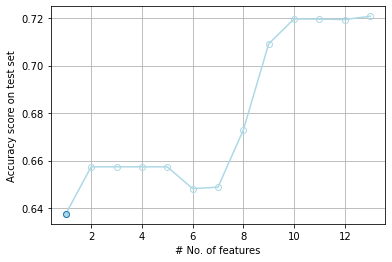

In [37]:
estimator = LogisticRegression()
acc_scores = []
for i in range(1, 14):
    selector = RFE(estimator, i)
    selector = selector.fit(X_train, y_train)
    supp = selector.get_support()

    predicted = selector.predict(X_test)
    acc_score = accuracy_score(y_test, predicted)
    acc_scores.append(acc_score)
  
best = 1
for item in acc_scores:
    if item < acc_scores[best - 1]:
        best = acc_scores.index(item) + 1

plt.grid()   
plt.xlabel('# No. of features')
plt.ylabel('Accuracy score on test set')
plt.plot(range(1, 14), acc_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'lightblue', markerfacecolor = 'None')
plt.plot(best, acc_scores[best-1], marker = 'o', markerfacecolor = 'lightblue')

Graphical representation of important features with their accuracy score.